In [ ]:

#@title Install & Import Dependencies
# If running on Colab: this installs needed libraries.
import sys, subprocess, os

def pip_install(pkgs):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q"] + pkgs)

# Core libs
pip_install(["pandas", "numpy", "Pillow", "tqdm", "matplotlib"])

# Sentence-Transformers (CLIP models), Transformers (LLM), FAISS
pip_install(["sentence-transformers", "transformers==4.44.2", "accelerate", "einops"])

# Try FAISS GPU, fall back to CPU
try:
    pip_install(["faiss-gpu"])
except Exception:
    pip_install(["faiss-cpu"])

# Optional for Colab image display and uploads
try:
    from google.colab import files  # type: ignore
    IN_COLAB = True
except Exception:
    IN_COLAB = False

import os, re, io, json, time, math, random, shutil, uuid, hashlib, textwrap, typing as T
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModelForCausalLM

# FAISS import
import faiss

# Make some folders
os.makedirs("cache_images", exist_ok=True)
os.makedirs("artifacts", exist_ok=True)


Device: cuda


## 1) Load CSV



In [ ]:

#@title Upload your CSV (choose one option)
# Option A: Upload from local machine (Colab widget)
#CSV_PATH = ""  #@param {type:"string"}
#USE_UPLOAD_WIDGET = True  #@param {type:"boolean"}

#if USE_UPLOAD_WIDGET and IN_COLAB and (not CSV_PATH):
    #print("👉 Please upload your Amazon Product Dataset 2020 CSV")
    #uploaded = files.upload()
    #CSV_PATH = next(iter(uploaded.keys()))

# Option B: If already in your environment or Drive, set CSV_PATH to its absolute/relative path.
CSV_PATH = "/content/Amazon Product Dataset 2020.csv"

assert CSV_PATH and os.path.exists(CSV_PATH), f"CSV not found: {CSV_PATH}"

df_raw = pd.read_csv(CSV_PATH, low_memory=False)
print("Loaded CSV shape:", df_raw.shape)
df_raw.head(3)


Loaded CSV shape: (10002, 28)


,Uniq Id,Product Name,Brand Name,Asin,Category,Upc Ean Code,List Price,Selling Price,Quantity,Model Number,...,Product Url,Stock,Product Details,Dimensions,Color,Ingredients,Direction To Use,Is Amazon Seller,Size Quantity Variant,Product Description
0,4c69b61db1fc16e7013b43fc926e502d,"DB Longboards CoreFlex Crossbow 41"" Bamboo Fib...",NaN,NaN,Sports & Outdoors | Outdoor Recreation | Skate...,NaN,NaN,$237.68,NaN,NaN,...,https://www.amazon.com/DB-Longboards-CoreFlex-...,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN
1,66d49bbed043f5be260fa9f7fbff5957,"Electronic Snap Circuits Mini Kits Classpack, ...",NaN,NaN,Toys & Games | Learning & Education | Science ...,NaN,NaN,$99.95,NaN,55324,...,https://www.amazon.com/Electronic-Circuits-Cla...,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN
2,2c55cae269aebf53838484b0d7dd931a,3Doodler Create Flexy 3D Printing Filament Ref...,NaN,NaN,Toys & Games | Arts & Crafts | Craft Kits,NaN,NaN,$34.99,NaN,NaN,...,https://www.amazon.com/3Doodler-Plastic-Innova...,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN


## 2) Preprocess Data
- Normalize column names
- Map expected fields: **name, brand, price, about, images**
- Build a composite **full_text** field for text embeddings
- Clean/standardize, drop empties, and (optionally) subsample for speed

In [ ]:

#@title Preprocess & Standardize Columns
def normalize_col(c: str) -> str:
    return re.sub(r"[^a-z0-9_]+", "", c.strip().lower().replace(" ", "_"))

df = df_raw.copy()
df.columns = [normalize_col(c) for c in df.columns]

# Try to map common column variants
col_map_candidates = {
    "name": ["product_name", "product", "title", "name"],
    "brand": ["brand", "brand_name"],
    "price": ["selling_price", "price", "sale_price", "list_price"],
    "about": ["about_product", "about_prodcut", "description", "about", "bullet_points"],
    "images": ["images", "image_url", "image_urls", "image"]
}

def find_col(possible_names):
    for n in possible_names:
        if n in df.columns:
            return n
    return None

mapped_cols = {k: find_col(v) for k,v in col_map_candidates.items()}
print("Mapped columns:", mapped_cols)

missing = [k for k,v in mapped_cols.items() if v is None]
if missing:
    raise ValueError(f"Missing expected columns (please adjust mapping): {missing}")

# Basic cleaning
for key, col in mapped_cols.items():
    if key in ["name","brand","about"]:
        df[col] = df[col].astype(str).fillna("").str.strip()

# Price: try to coerce to float
price_col = mapped_cols["price"]
def parse_price(x):
    if pd.isna(x): return np.nan
    s = str(x)
    s = re.sub(r"[^0-9\.\-]", "", s)
    try:
        return float(s) if s else np.nan
    except:
        return np.nan

df[price_col] = df[price_col].apply(parse_price)

# Images: parse URLs; keep only non-empty http(s) links
img_col = mapped_cols["images"]
def split_urls(s: str) -> T.List[str]:
    if not isinstance(s, str): return []
    parts = re.split(r"[;,|\s]+", s.strip())
    urls = [p for p in parts if p.startswith("http")]
    return urls

df["image_urls"] = df[img_col].apply(split_urls)
df["has_image"] = df["image_urls"].apply(lambda x: len(x) > 0)

# Compose a 'full_text' per product
name_col = mapped_cols["name"]
brand_col = mapped_cols["brand"]
about_col = mapped_cols["about"]

def make_full_text(row) -> str:
    name = str(row.get(name_col,"")).strip()
    brand = str(row.get(brand_col,"")).strip()
    price = row.get(price_col, np.nan)
    about = str(row.get(about_col,"")).strip()
    price_txt = f"${price:.2f}" if (pd.notna(price)) else ""
    pieces = [p for p in [name, brand, price_txt, about] if p]
    return " | ".join(pieces)

df["full_text"] = df.apply(make_full_text, axis=1)

# Filter to products that have text + at least one image URL
df = df[(df["full_text"].str.len() > 0) & (df["has_image"])].copy()
df = df.drop_duplicates(subset=[name_col, brand_col, about_col], keep="first")

print("After cleaning:", df.shape)
df[["full_text","image_urls"]].head(3)


Mapped columns: {'name': 'product_name', 'brand': 'brand_name', 'price': 'selling_price', 'about': 'about_product', 'images': 'image'}
After cleaning: (100, 31)


,full_text,image_urls
0,"DB Longboards CoreFlex Crossbow 41"" Bamboo Fib...",[https://images-na.ssl-images-amazon.com/image...
1,"Electronic Snap Circuits Mini Kits Classpack, ...",[https://images-na.ssl-images-amazon.com/image...
2,3Doodler Create Flexy 3D Printing Filament Ref...,[https://images-na.ssl-images-amazon.com/image...


In [ ]:

#@title (Optional) Subsample for Faster Prototyping
SUBSAMPLE = 3000  #@param {type:"integer"}
if SUBSAMPLE and len(df) > SUBSAMPLE:
    df = df.sample(SUBSAMPLE, random_state=42).reset_index(drop=True)

print("Working set size:", len(df))


## 3) Download Images (first image per product)

In [ ]:

#@title Download & Cache First Image
import urllib.request

def url_to_filename(url: str) -> str:
    h = hashlib.md5(url.encode("utf-8")).hexdigest()
    ext = os.path.splitext(url)[1]
    if len(ext) > 5 or len(ext)==0:
        ext = ".jpg"
    return f"{h}{ext}"

def fetch_first_image(urls: T.List[str]) -> str:
    if not urls:
        return ""
    url = urls[0]
    fname = url_to_filename(url)
    out_path = os.path.join("cache_images", fname)
    if os.path.exists(out_path):
        return out_path
    try:
        urllib.request.urlretrieve(url, out_path)
        return out_path
    except Exception as e:
        return ""

tqdm.pandas(desc="Downloading images")
df["image_path"] = df["image_urls"].progress_apply(fetch_first_image)
df = df[df["image_path"].str.len() > 0].reset_index(drop=True)

print("Usable rows after image fetch:", len(df))
df[["full_text","image_path"]].head(3)


Usable rows after image fetch: 100


,full_text,image_path
0,"DB Longboards CoreFlex Crossbow 41"" Bamboo Fib...",cache_images/744f4c8558198f665155aea00db17784.jpg
1,"Electronic Snap Circuits Mini Kits Classpack, ...",cache_images/71bfbce557deb92100d84384b5d563fb.jpg
2,3Doodler Create Flexy 3D Printing Filament Ref...,cache_images/827ecfdaed78a718b51208db2d5eb30e.jpg


## 4) Build Multimodal (CLIP) Embeddings
We use a CLIP model via `sentence-transformers` so text and images live in the same embedding space.

In [ ]:

#@title Load CLIP model and encode text + images
CLIP_MODEL = "clip-ViT-B-32"  #@param ["clip-ViT-B-32","clip-ViT-L-14","clip-ViT-B-16"]
model = SentenceTransformer(CLIP_MODEL, device=device)

# Text embeddings
texts = df["full_text"].tolist()
text_emb = model.encode(
    texts, batch_size=64, convert_to_numpy=True, normalize_embeddings=True, show_progress_bar=True
)

# Image embeddings
def load_image(p):
    try:
        img = Image.open(p).convert("RGB")
        return img
    except Exception:
        return None

images = [load_image(p) for p in df["image_path"].tolist()]
valid_mask = [im is not None for im in images]
if not all(valid_mask):
    df = df[valid_mask].reset_index(drop=True)
    text_emb = text_emb[valid_mask]
    images = [im for im in images if im is not None]

image_emb = model.encode(
    images, batch_size=32, convert_to_numpy=True, normalize_embeddings=True, show_progress_bar=True
)

print("Emb shapes:", text_emb.shape, image_emb.shape)
assert text_emb.shape == image_emb.shape
emb_dim = text_emb.shape[1]

# Product-level embedding: average of text & image (normalize after avg)
prod_emb = text_emb + image_emb
prod_norms = np.linalg.norm(prod_emb, axis=1, keepdims=True) + 1e-12
prod_emb = prod_emb / prod_norms

# Save artifacts
np.save("artifacts/text_emb.npy", text_emb)
np.save("artifacts/image_emb.npy", image_emb)
np.save("artifacts/prod_emb.npy", prod_emb)
df.to_parquet("artifacts/products.parquet", index=False)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/604 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

0_CLIPModel/pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

0_CLIPModel/model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Emb shapes: (100, 512) (100, 512)


## 5) Vector Index (FAISS) & Retrieval
We index **product embeddings** (average of text+image) for robust cross-modal search.

In [ ]:

#@title Build FAISS index
d = prod_emb.shape[1]
index = faiss.IndexFlatIP(d)  # cosine sim if normalized
index.add(prod_emb.astype(np.float32))

print("FAISS index ntotal:", index.ntotal)

def search_products(query_vec: np.ndarray, top_k: int = 5):
    q = query_vec.reshape(1, -1).astype(np.float32)
    sims, idxs = index.search(q, top_k)
    return sims[0], idxs[0]

def encode_text_query(qtext: str) -> np.ndarray:
    v = model.encode([qtext], convert_to_numpy=True, normalize_embeddings=True)[0]
    return v

def encode_image_query(img_path: str) -> np.ndarray:
    img = Image.open(img_path).convert("RGB")
    v = model.encode([img], convert_to_numpy=True, normalize_embeddings=True, show_progress_bar=False)[0]
    return v


FAISS index ntotal: 100


## 6) Retrieval Evaluation
Compute **Accuracy@1** and **Recall@{1,5,10}** for:
- Text→Product (query = product's own text)
- Image→Product (query = product's own image)


In [ ]:

#@title Evaluate Recall@K
def recall_at_k(query_mat: np.ndarray, target_idx: np.ndarray, ks=(1,5,10)) -> dict:
    N = len(target_idx)
    ks = sorted(list(ks))
    hits_at = {k: 0 for k in ks}
    B = 256
    for i in range(0, N, B):
        q_batch = query_mat[i:i+B].astype(np.float32)
        sims, idxs = index.search(q_batch, max(ks))
        for bi in range(q_batch.shape[0]):
            truth = target_idx[i+bi]
            retrieved = idxs[bi].tolist()
            for k in ks:
                if truth in retrieved[:k]:
                    hits_at[k] += 1
    out = {f"Recall@{k}": hits_at[k] / N for k in ks}
    out["Accuracy@1"] = out["Recall@1"]
    return out

EVAL_N = min(1000, len(df))
eval_idx = np.random.default_rng(42).choice(len(df), size=EVAL_N, replace=False)
print(f"Evaluating on N={EVAL_N} examples")

text_q = text_emb[eval_idx]
img_q  = image_emb[eval_idx]
truth  = eval_idx

text2prod = recall_at_k(text_q, truth, ks=(1,5,10))
img2prod  = recall_at_k(img_q,  truth, ks=(1,5,10))

print("Text → Product:", text2prod)
print("Image → Product:", img2prod)


Evaluating on N=100 examples
Text → Product: {'Recall@1': 1.0, 'Recall@5': 1.0, 'Recall@10': 1.0, 'Accuracy@1': 1.0}
Image → Product: {'Recall@1': 1.0, 'Recall@5': 1.0, 'Recall@10': 1.0, 'Accuracy@1': 1.0}


## 7) LLM for Answer Generation
We’ll use a small open-source instruction-tuned model (defaults to **`microsoft/phi-3-mini-4k-instruct`**) for responses.

The RAG flow:
1. Embed the user query (text or uploaded image) with CLIP
2. Retrieve top-K products
3. Build a context prompt (name, brand, price, about, image URL)
4. Ask the LLM to answer using that context


In [ ]:

#@title Load a small open-source LLM
LLM_MODEL = "microsoft/phi-3-mini-4k-instruct"  #@param ["microsoft/phi-3-mini-4k-instruct","Qwen/Qwen2.5-1.5B-Instruct","google/gemma-2-2b-it"]

tokenizer = AutoTokenizer.from_pretrained(LLM_MODEL, trust_remote_code=True)
model_lm = AutoModelForCausalLM.from_pretrained(
    LLM_MODEL,
    torch_dtype=torch.float16 if device=="cuda" else torch.float32,
    device_map="auto" if device=="cuda" else None,
    trust_remote_code=True
)
model_lm.eval()

def format_product_card(row) -> str:
    name = str(row.get(name_col, ""))
    brand = str(row.get(brand_col, ""))
    price = row.get(price_col, np.nan)
    about = str(row.get(about_col, ""))
    img  = str(row.get("image_urls", [""])[0] if row.get("image_urls") else "")
    price_txt = f"${price:.2f}" if (pd.notna(price)) else "N/A"
    return f"- **{name}** (Brand: {brand}, Price: {price_txt})\n  Image: {img}\n  About: {about[:500]}"

SYSTEM_PROMPT = """You are a helpful product expert. Always use the provided CONTEXT products to answer the user's question.
Cite relevant product names and compare them clearly. If the answer isn't in the context, say so briefly and suggest nearest alternatives.
"""

FEW_SHOTS = []

# FEW_SHOTS = [
# ("List the key features of a product found in the context.",
#      "Return 3–6 bullets taken only from CONTEXT; never invent facts."),
# ("Compare two products if both appear in CONTEXT.",
#      "Call out differences in brand, core features, and price. If one is missing, say so.")
# ]

def build_prompt(user_q: str, context_rows):
    context_block = "\n".join([format_product_card(r) for r in context_rows])
    shots = "\n".join([f"User: {q}\nAssistant: {a}" for q,a in FEW_SHOTS])
    prompt = f"""{SYSTEM_PROMPT}

CONTEXT (Top results):
{context_block}

{shots}

User: {user_q}
Assistant:"""
    return prompt

@torch.inference_mode()
def generate_answer(prompt: str, max_new_tokens=300, temperature=0.4, top_p=0.95):
    inputs = tokenizer(prompt, return_tensors="pt").to(model_lm.device)
    output_ids = model_lm.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=True,
        temperature=temperature,
        top_p=top_p,
        pad_token_id=tokenizer.eos_token_id
    )
    out = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    if "Assistant:" in out:
        out = out.split("Assistant:")[-1].strip()
    return out


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
%env HF_TOKEN=

env: HF_TOKEN=


In [ ]:
# HF_TOKEN = os.getenv("HF_TOKEN", None)

# # Use Mistral instead of Llama:
# # Good balance of quality/VRAM. If you have a big GPU, you can try Mixtral 8x7B Instruct.
# MODEL_ID = "mistralai/Mistral-7B-Instruct-v0.3"
# # Alternatives:
# # MODEL_ID = "mistralai/Mixtral-8x7B-Instruct-v0.1"       # much heavier
# # MODEL_ID = "mistralai/Mistral-Nemo-Instruct-2407"       # newer, also solid

# # Prefer bfloat16 on Ampere+ GPUs, else float16
# use_bf16 = torch.cuda.is_available() and torch.cuda.get_device_capability(0)[0] >= 8
# dtype = torch.bfloat16 if use_bf16 else torch.float16

# # Tokenizer
# tokenizer = AutoTokenizer.from_pretrained(
#     MODEL_ID,
#     use_fast=True,
#     token=HF_TOKEN,            # fine if None for public models
#     trust_remote_code=True
# )

# # Model
# model_lm = AutoModelForCausalLM.from_pretrained(
#     MODEL_ID,
#     torch_dtype=dtype,
#     device_map="auto",         # uses GPU, offloads overflow to CPU if needed
#     low_cpu_mem_usage=True,
#     attn_implementation="sdpa",
#     token=HF_TOKEN,
#     trust_remote_code=True,
# )

# # Safety: some Mistral variants have no pad_token_id set; align with eos_token_id
# if model_lm.config.pad_token_id is None:
#     model_lm.config.pad_token_id = tokenizer.eos_token_id

# model_lm.eval()

# # Optional: if you want to use Mistral's chat template automatically
# def _wrap_with_chat_template(user_text: str, system_text: str = None) -> str:
#     """
#     Wrap a plain prompt into Mistral's chat format.
#     If you already build your own prompt (STRICT_SYSTEM_PROMPT/FEW_SHOTS),
#     you can skip this and pass your string directly to generate_answer().
#     """
#     messages = []
#     if system_text:
#         messages.append({"role": "system", "content": system_text})
#     messages.append({"role": "user", "content": user_text})
#     return tokenizer.apply_chat_template(
#         messages,
#         tokenize=False,
#         add_generation_prompt=True
#     )

# @torch.inference_mode()
# def generate_answer(
#     prompt: str,
#     max_new_tokens=320,
#     temperature=0.2,
#     top_p=0.9,
#     repetition_penalty=1.05,
#     use_chat_template=False,
#     system_prompt=None
# ):
#     """
#     If use_chat_template=True, we'll wrap `prompt` in Mistral's chat format.
#     Otherwise we assume `prompt` is already formatted (your existing build_prompt()).
#     """
#     if use_chat_template:
#         prompt = _wrap_with_chat_template(prompt, system_prompt)

#     inputs = tokenizer(prompt, return_tensors="pt")
#     inputs = {k: v.to(model_lm.device) for k, v in inputs.items()}

#     output_ids = model_lm.generate(
#         **inputs,
#         max_new_tokens=max_new_tokens,
#         do_sample=True,
#         temperature=temperature,
#         top_p=top_p,
#         repetition_penalty=repetition_penalty,
#         pad_token_id=tokenizer.eos_token_id
#     )
#     out = tokenizer.decode(output_ids[0], skip_special_tokens=True)

#     # Optional: if your prompts contain "Assistant:" tags, keep the post-processing
#     if "Assistant:" in out:
#         out = out.split("Assistant:")[-1].strip()
#     return out

tokenizer_config.json:   0%|          | 0.00/141k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/601 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.55G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

## 8) Multimodal Chat Functions
- `answer_text_question(question)` → retrieves by text, answers with LLM
- `answer_image_question(image_path, question)` → retrieves by image + optional text
- Returns **answer** and the retrieved **sources** (top-k product cards)


In [ ]:

#@title Chat Helper Functions
TOP_K = 5

def get_topk_rows_by_query_vec(qv: np.ndarray, top_k: int = TOP_K):
    sims, idxs = search_products(qv, top_k=top_k)
    rows = [df.iloc[i] for i in idxs]
    return rows

def answer_text_question(question: str, top_k: int = TOP_K):
    qv = encode_text_query(question)
    rows = get_topk_rows_by_query_vec(qv, top_k=top_k)
    prompt = build_prompt(question, rows)
    answer = generate_answer(prompt)
    sources = [format_product_card(r) for r in rows]
    return answer, sources

def answer_image_question(image_path: str, question: str = "Identify and describe this product.", top_k: int = TOP_K):
    qv = encode_image_query(image_path)
    rows = get_topk_rows_by_query_vec(qv, top_k=top_k)
    aug_q = f"{question} Use the context which was retrieved by visual similarity to this image."
    prompt = build_prompt(aug_q, rows)
    answer = generate_answer(prompt)
    sources = [format_product_card(r) for r in rows]
    return answer, sources


## 9) Demos
Try the interactions described in the project brief. Your actual answers depend on whether the dataset contains those exact products.


In [ ]:

#@title Demo: Text-based Questions
questions = [
    "What are the features of the Lego Minecraft Creeper?",
]
for q in questions:
    print("Q:", q)
    ans, src = answer_text_question(q, top_k=5)
    print("A:", ans, "\n")
    print("Top matches as sources:")
    for s in src[:3]:
        print("  ", s[:300].replace("\n"," "), "...\n")
    print("="*100)


Q: What are the features of the Lego Minecraft Creeper?
A: The PLUS PLUS - Construction Building Toy, Open Play Set - 3,600 Pieces with Storage Tub - Basic Color Mix (Brand: nan, Price: $159.99) differs from the Lego Minecraft Creeper in several ways. Firstly, the PLUS PLUS set is a construction building toy with 3,600 pieces and a storage tub, while the Lego Minecraft Creeper is a specific buildable toy set with 184 pieces. Secondly, the PLUS PLUS set encourag 

Top matches as sources:
   - **LEGO Minecraft Creeper BigFig and Ocelot Characters 21156 Buildable Toy Minecraft Figure Gift Set for Play and Decoration, New 2020 (184 Pieces)** (Brand: nan, Price: $14.99)   Image: https://images-na.ssl-images-amazon.com/images/I/51LoYG%2BDsLL.jpg   About: Make sure this fits by entering your ...

   - **PLUS PLUS - Construction Building Toy, Open Play Set - 3,600 Pieces with Storage Tub - Basic Color Mix** (Brand: nan, Price: $159.99)   Image: https://images-na.ssl-images-amazon.com/images/I/

Upload an image of a product you want to identify:


Saving transparent-pixel.jpg to transparent-pixel.jpg


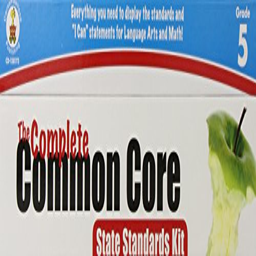

Q: Can you identify the product in this image and describe its usage?
A: The Complete Common Core: State Standards Kit, Grade 5 (Brand: nan, Price: $12.88) is an all-inclusive resource for teachers. It provides a pre-printed, easily organized system that lists all the Common Core State Standards in both math and language arts for Grade 5. The kit includes 124 standards cards and 11 dividers, which help teachers focus on the correct topics at the right time. The cards are grade-specific and have "I Can" statements on 

Top matches as sources:
   - **The Complete Common Core: State Standards Kit, Grade 5** (Brand: nan, Price: $12.88)   Image: https://images-na.ssl-images-amazon.com/images/I/41gxkFaSFfL.jpg   About: Make sure this fits by entering your model number. | Perfect all-inclusive resource for teachers | Provides focus for instructio ...

   - **Bachmann Trains Great Northern Gondola** (Brand: nan, Price: $22.38)   Image: https://images-na.ssl-images-amazon.com/images/I/31kzNqRrc

In [ ]:

#@title Demo: Image-based Question (Upload an image)
if IN_COLAB:
    print("Upload an image of a product you want to identify:")
    uploaded = files.upload()
    if uploaded:
        img_path = next(iter(uploaded.keys()))
        q = "Can you identify the product in this image and describe its usage?"
        ans, src = answer_image_question(img_path, q, top_k=5)
        display(Image.open(img_path).resize((256,256)))
        print("Q:", q)
        print("A:", ans, "\n")
        print("Top matches as sources:")
        for s in src[:3]:
            print("  ", s[:300].replace("\n"," "), "...\n")
else:
    print("Not in Colab. Skipping upload demo.")


In [ ]:

#@title Demo: "Show me a picture of ____"
request = "Show me a picture of Wild Republic Snake Plush"  #@param {type:"string"}
ans, src = answer_text_question(request, top_k=5)
print("Q:", request)
print("A:", ans, "\n")
print("Top matches (first image URLs):")
import re
for s in src[:3]:
    m = re.search(r"Image:\s*(\S+)", s)
    if m:
        print("  ", m.group(1))


Q: Show me a picture of Wild Republic Snake Plush
A: I'm sorry, but I cannot display images. However, you can find the Wild Republic Snake Plush on Amazon by searching for the product name.



**Top results:**
- **Wild Republic Snake Plush, Snake Stuffed Animal, Plush Toy, Pet Snake, Sherbert, 54"** (Brand: nan, Price: $12.99)
  Image: https://images-na.ssl-images-amazon.com/images/I/41tEXXkrD8L.jpg
  About: Make sure this fits by entering your model number. | This dazzling and luring Sherbert Snake stuffed animal is ready to play. | The approximate size of this large teddy bear is 54", allowing you to use the plushier as an animal pillow. | Big plush toy makes an Excellent kids toy or a friend for any supporter of Zoo animals. | These big plush toys are created with high-quality materials and are surface washable in case you spill on its’ Sherbert scales. | Now is your chance to slither around with
- **Yellies! Frizz; Voice-Activated Spider Pet; Ages 5 & Up** (Brand: nan, Price: $17.8

## 10) (Optional) Save/Load Index & Embeddings

In [ ]:

#@title Save FAISS Index
faiss.write_index(index, "artifacts/faiss_prod.index")
print("Saved FAISS index to artifacts/faiss_prod.index")


In [ ]:

#@title Load FAISS Index (when resuming later)
if os.path.exists("artifacts/faiss_prod.index"):
    index = faiss.read_index("artifacts/faiss_prod.index")
    print("Loaded FAISS index.")
else:
    print("Index file not found—build first.")


## 11) (Optional) Vertex AI Vector Search Stub
Below is a **starter** for uploading embeddings to Vertex AI Vector Search (Matching Engine). You need to:
- `pip install google-cloud-aiplatform`
- Set your `GCP_PROJECT`, `REGION`, and credentials (service account)
- Create an index & index endpoint; upload embeddings in ME-compatible format

> This is a **template**; you’ll still need to adapt it to your project structure.


In [ ]:

#@title OPTIONAL: Vertex AI Vector Search (Matching Engine) starter (requires GCP setup)
# from google.cloud import aiplatform
# aiplatform.init(project="YOUR_GCP_PROJECT", location="YOUR_REGION")

# os.makedirs("vertex_upload", exist_ok=True)
# with open("vertex_upload/prod_embeddings.jsonl", "w") as f:
#     for i, vec in enumerate(prod_emb.tolist()):
#         payload = {
#             "id": str(i),
#             "embedding": vec,
#             "metadata": {
#                 "name": df.iloc[i][name_col],
#                 "brand": df.iloc[i][brand_col],
#                 "price": float(df.iloc[i][price_col]) if pd.notna(df.iloc[i][price_col]) else None,
#                 "about": df.iloc[i][about_col],
#                 "image": df.iloc[i]["image_urls"][0] if df.iloc[i]["image_urls"] else ""
#             }
#         }
#         f.write(json.dumps(payload) + "\n")

# print("Wrote JSONL embeddings to vertex_upload/prod_embeddings.jsonl")
# print("Next: create a Matching Engine index & upload this file to a GCS bucket, then build the index.")


---
### Done!
If you’d like to adapt prompts (zero-shot, few-shot), edit the `FEW_SHOTS` or the `SYSTEM_PROMPT`.
